In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import scipy.integrate
import scipy.interpolate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import os
# For parallelization
from joblib import Parallel, delayed

import lmfit
import nekhoroshev_tools as nt

### Gathering B1 data to fit...

In [2]:
I_min = 0.0

In [3]:
with open("b1_160.pkl", 'rb') as f:
    t_160, loss_160, intensity_160 = pickle.load(f)

with open("b1_150.pkl", 'rb') as f:
    t_150, loss_150, intensity_150 = pickle.load(f)

with open("b1_140.pkl", 'rb') as f:
    t_140, loss_140, intensity_140 = pickle.load(f)

with open("b1_130.pkl", 'rb') as f:
    t_130, loss_130, intensity_130 = pickle.load(f)

In [4]:
norm_loss_160 = np.empty_like(loss_160)

for i in range(len(loss_160)):
    norm_loss_160[i] = 1 - scipy.integrate.trapz(loss_160[:i]/intensity_160, t_160[:i])

norm_loss_150 = np.empty_like(loss_150)

for i in range(len(loss_150)):
    norm_loss_150[i] = norm_loss_160[-1] - scipy.integrate.trapz(loss_150[:i]/intensity_160, t_150[:i])

norm_loss_140 = np.empty_like(loss_140)

for i in range(len(loss_140)):
    norm_loss_140[i] = norm_loss_150[-1] - scipy.integrate.trapz(loss_140[:i]/intensity_160, t_140[:i])

norm_loss_130 = np.empty_like(loss_130)

for i in range(len(loss_130)):
    norm_loss_130[i] = norm_loss_140[-1] - scipy.integrate.trapz(loss_130[:i]/intensity_160, t_130[:i])

t_ratio_160 = t_160[-1] / t_160[-1]
t_ratio_150 = (t_150[-1] - t_150[0]) / t_160[-1]
t_ratio_140 = (t_140[-1] - t_140[0]) / t_160[-1]
t_ratio_130 = (t_130[-1] - t_130[0]) / t_160[-1]

In [5]:
t_150[0]

27844149.331245005

In [6]:
t_150[-1] / t_160[-1]

1.5417123424932906

In [7]:
t_140

array([42237648.12624501, 42248915.605     , 42252918.836245  , ...,
       54348636.81      , 54359780.605     , 54371261.761245  ])

In [8]:
print(t_ratio_160)
print(t_ratio_150)
print(t_ratio_140)
print(t_ratio_130)

1.0
0.5185727238356537
0.445852400795823
3.1172570955752468


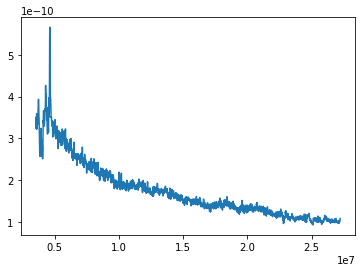

In [9]:
plt.plot(t_160, loss_160/intensity_160, label='160')

In [10]:
normalized_loss = np.empty_like(loss_160)

for i in tqdm(range(len(loss_160))):
    normalized_loss[i] = 1 - scipy.integrate.trapz(loss_160[:i]/intensity_160, t_160[:i])

  0%|          | 0/2320 [00:00<?, ?it/s]

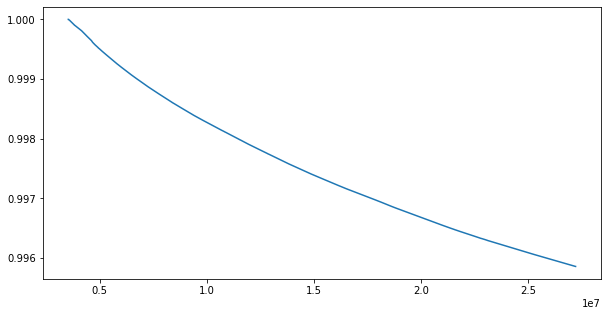

In [11]:
plt.figure(figsize=(10,5))
plt.plot(t_160, normalized_loss, label='160')

In [12]:
x = t_160 - t_160[0]
y = loss_160/intensity_160

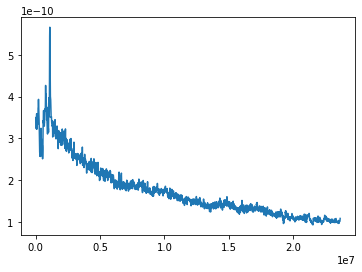

In [13]:
plt.plot(x, y)

In [14]:
all_t = np.concatenate((t_160, t_150, t_140, t_130))
all_loss = np.concatenate((loss_160, loss_150, loss_140, loss_130))/intensity_160

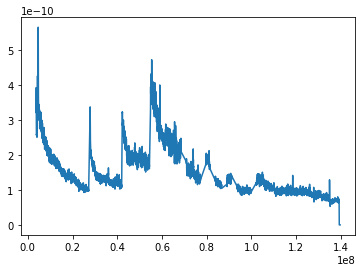

In [15]:
plt.plot(all_t, all_loss)

In [24]:
all_normalized_intensity = np.empty_like(all_loss)

for i in range(len(all_loss)):
    all_normalized_intensity[i] = 1 - scipy.integrate.trapz(all_loss[:i], all_t[:i])

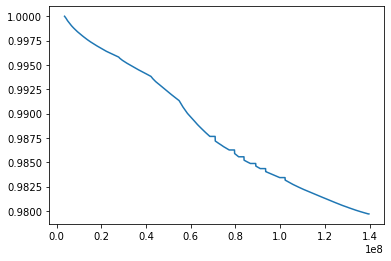

In [25]:
plt.plot(all_t, all_normalized_intensity)

In [9]:
def resid_test(p, x, y):
    k = p["k"].value
    p["test"].value = 2.5
    model = np.exp(-k * x)
    return (y - model)

x = np.linspace(1, 10, 1000)
y = np.exp(-3 * x)

params = lmfit.Parameters()
params.add("k", value=1.0)
params.add("test", value=-1.0)

result = lmfit.minimize(resid_test, params, args=(x, y))
result

In [5]:
def full_iteration(I_star, k, I_max, I0, dt, n_steps=10000):
    engine = cn.cn_generic(I_min, I_max, I0, dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)

    vals = []
    data = engine.get_data_with_x()
    vals.append(scipy.integrate.trapz(data[1], data[0]))

    data_0 = engine.get_data_with_x()

    for i in range(n_steps):
        engine.iterate(1)
        data = engine.get_data_with_x()
        vals.append(scipy.integrate.trapz(data[1], data[0]))
    
    data_1 = engine.get_data_with_x()

    return vals, data_0, data_1, engine

In [6]:
def compute_loss(engine: cn.cn_generic, starting_point: float, iterations=10000):
    vals = []
    rel_vals = [starting_point]
    data = engine.get_data_with_x()
    vals.append(scipy.integrate.trapz(data[1], data[0]))

    real_val = vals[0] / starting_point

    data_0 = engine.get_data_with_x()

    for i in range(iterations):
        engine.iterate(1)
        data = engine.get_data_with_x()
        vals.append(scipy.integrate.trapz(data[1], data[0]))
        rel_vals.append(vals[-1]/(real_val))
    
    data_1 = engine.get_data_with_x()

    return vals, rel_vals, data_0, data_1

In [7]:
def iterate_to_loss(engine: cn.cn_generic, starting_point: float, ending_point: float, maximum_iterations=100000):
    vals = []
    rel_vals = [starting_point]
    data = engine.get_data_with_x()
    vals.append(scipy.integrate.trapz(data[1], data[0]))

    real_val = vals[0] / starting_point

    reached = False

    for i in range(maximum_iterations):
        engine.iterate(1)
        data = engine.get_data_with_x()
        vals.append(scipy.integrate.trapz(data[1], data[0]))
        rel_vals.append(vals[-1]/(real_val))
        if rel_vals[-1] < ending_point:
            reached = True
            break

    if not reached:
        print("Reached maximum iterations")
        return reached, None, None, None
    else:
        # print("Reached after {} iterations".format(i))
        return reached, vals, rel_vals, i

In [8]:
def test_parameters(I_star: float, k: float, I_max: float, starting_point: float, ending_point: float, I0=None):
    I_min = 0.0
    dt = 1.0
    if I0 is None:
        I0 = np.exp(-np.linspace(I_min, I_max, samples))
    while True:
        # print("dt: {}".format(dt))
        engine = cn.cn_generic(I_min, I_max, I0, dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)
        reached, vals, rel_vals, i = iterate_to_loss(engine, starting_point, ending_point)
        if reached:
            break
        else:
            print("I_star: {}, k: {}".format(I_star, k))
            dt *= 10
    
    new_dt = i * dt / 10000
    engine = cn.cn_generic(I_min, I_max, I0, new_dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)
    vals, rel_vals, data_0, data_1 = compute_loss(engine, starting_point)
    return vals, rel_vals, new_dt
    

In [9]:
def align_time(t_data: np.ndarray, l_data: np.ndarray, t_model: np.ndarray, l_model: np.ndarray):
    t_data -= t_data[0]
    t_final = t_data[-1]
    scale_factor = t_final / t_model[-1]
    t_model *= scale_factor
    f_interp = scipy.interpolate.interp1d(t_model, l_model, kind='cubic', bounds_error=False, fill_value="extrapolate")
    return t_data, l_data, f_interp(t_data), scale_factor

In [10]:
def resid_lmfit(params, t_data, l_data, I0=None):
    I_star = params['I_star'].value
    k = params['k'].value
    I_max = params['I_max'].value
    starting_point = params['starting_point'].value
    ending_point = params['ending_point'].value
    print("I_star: {}".format(I_star), "k: {}".format(k))
    vals, rel_vals, new_dt = test_parameters(I_star, k, I_max, starting_point, ending_point, I0)
    t_data, l_data, l_model, scale_factor = align_time(t_data, l_data, np.arange(len(rel_vals))*new_dt, rel_vals)

    params['dt'].value = new_dt
    params['scale_factor'].value = scale_factor
    params['n_iterations'].value = 10000

    return l_data - l_model


def resid_fixed_dt(params, t_data, l_data, I0=None):
    I_star = params['I_star'].value
    k = params['k'].value
    I_max = params['I_max'].value
    starting_point = params['starting_point'].value
    ending_point = params['ending_point'].value
    dt = params['dt'].value
    n_iterations = params['n_iterations'].value
    scale_factor = params['scale_factor'].value
    I_min = 0.0
    
    # print("I_star: {}".format(I_star))
    # print("k: {}".format(k))
    
    engine = cn.cn_generic(I_min, I_max, I0, dt, lambda x : nt.D(x, I_star, k, nt.standard_c(0.0, I_max, I_star, k), True), False)
    vals, rel_vals, data_0, data_1 = compute_loss(engine, starting_point, n_iterations)
    times = np.arange(len(rel_vals)) * dt * scale_factor
    interp_func = scipy.interpolate.interp1d(times, rel_vals, kind='cubic')
    return l_data - interp_func(t_data)

In [11]:
I_min = 0.0
I_max = 10.5
samples = 3000

In [36]:
print("ANGLE: 160")
params = lmfit.Parameters()

params.add('I_star', value=50.0, min=0.0, max=1000.0)
params.add('k', value=0.9, min=0.0, max=2.0)
params.add('I_max', value=10.5, vary=False)

params.add('starting_point', value=norm_loss_160[0], vary=False)
params.add('ending_point', value=norm_loss_160[-1], vary=False)

params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)


I_160 = np.exp(-np.linspace(I_min, I_max, samples))
result_160 = lmfit.minimize(resid_lmfit, params, args=(t_160, norm_loss_160, I_160))

ANGLE: 160
I_star: 49.999999999999986
k: 0.9
dt: 1.0
Reached after 571 iterations
I_star: 49.999999999999986
k: 0.9
dt: 1.0
Reached after 571 iterations
I_star: 49.999999999999986
k: 0.9
dt: 1.0
Reached after 571 iterations
I_star: 50.00000363660023
k: 0.9
dt: 1.0
Reached after 571 iterations
I_star: 49.999999999999986
k: 0.9000000014851292
dt: 1.0
Reached after 571 iterations
I_star: 156.99941688918494
k: 0.4529146692771968
dt: 1.0
Reached after 101 iterations
I_star: 58.38242243189279
k: 0.8533821335002587
dt: 1.0
Reached after 553 iterations
I_star: 58.38242621469308
k: 0.8533821335002587
dt: 1.0
Reached after 553 iterations
I_star: 58.38242243189279
k: 0.8533821356692437
dt: 1.0
Reached after 553 iterations
I_star: 77.9496523882901
k: 0.7716317217904172
dt: 1.0
Reached after 476 iterations
I_star: 77.94965640269524
k: 0.7716317217904172
dt: 1.0
Reached after 476 iterations
I_star: 77.9496523882901
k: 0.7716317251329405
dt: 1.0
Reached after 476 iterations
I_star: 38.22092217548828


In [37]:
result_160

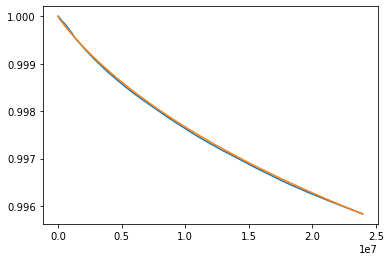

In [38]:
plt.plot(t_160, norm_loss_160)
plt.plot(t_160, norm_loss_160 - result_160.residual)

In [39]:
vals, data0, data1, _ = full_iteration(
    result_160.params['I_star'].value,
    result_160.params['k'].value,
    result_160.params['I_max'].value,
    I_160,
    result_160.params['dt'].value,
    n_steps=10000)
val0 = vals[0]
I_150 = data1[1]

v_f = scipy.interpolate.interp1d(np.arange(len(vals))*result_160.params['dt']*result_160.params['scale_factor'], vals / val0, kind='cubic')

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


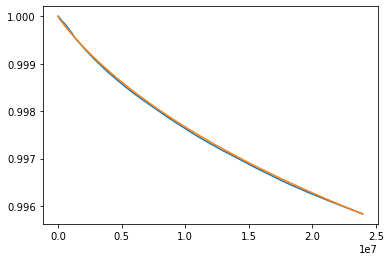

In [40]:
v_f = scipy.interpolate.interp1d(np.arange(len(vals))*result_160.params['dt']*result_160.params['scale_factor'], vals / val0, kind='cubic')
plt.plot(t_160, norm_loss_160)
plt.plot(t_160, v_f(t_160))

In [41]:
vals, data0, data1, _ = full_iteration(
    result_160.params['I_star'].value,
    result_160.params['k'].value,
    result_160.params['I_max'].value,
    I_150,
    result_160.params['dt'].value,
    n_steps=10000)
I_150_bis = data1[1]

v_f = scipy.interpolate.interp1d(np.arange(len(vals))*result_160.params['dt']*result_160.params['scale_factor'], vals / val0, kind='cubic')

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


ValueError: A value in x_new is above the interpolation range.

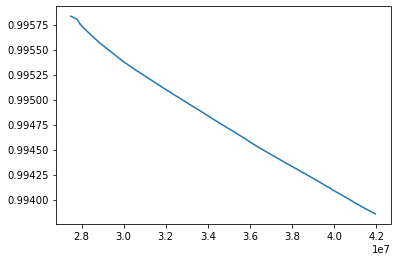

In [42]:
plt.plot(t_150, norm_loss_150)
plt.plot(t_150, v_f(t_150))

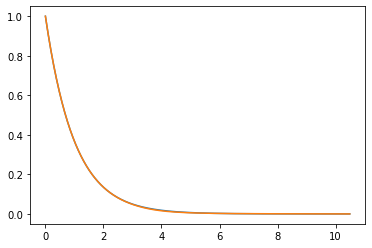

In [100]:
plt.plot(data0[0], data0[1])
plt.plot(data1[0], data1[1])

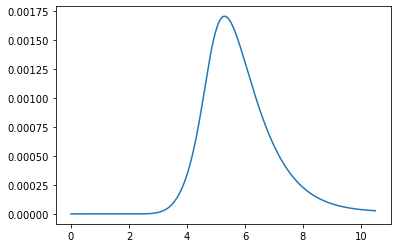

In [128]:
plt.plot(data0[0], data0[1] - data1[1])

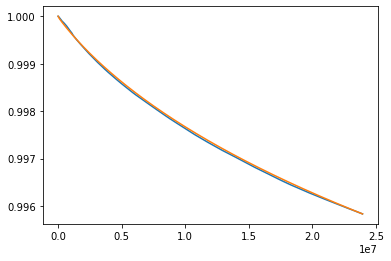

In [115]:
plt.plot(t_160, norm_loss_160)
plt.plot(t_160, norm_loss_160 - result_160.residual)

In [43]:
print("ANGLE: 150")
params = lmfit.Parameters()
params.add('I_star', value=result_160.params['I_star'].value, min=0.0, max=200.0)
params.add('k', value=result_160.params['k'].value, min=0.0, max=1.5)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_150[0], vary=False)
params.add('ending_point', value=norm_loss_150[-1], vary=False)
params.add('dt', value=result_160.params['dt'].value, vary=False)
params.add('n_iterations', value=int(10000*t_ratio_150)+1, vary=False)
params.add('scale_factor', value=result_160.params["scale_factor"].value, vary=False)

result_150 = lmfit.minimize(resid_lmfit, params, args=(t_150, norm_loss_150, I_150))


ANGLE: 150
I_star: 77.9389129675141
k: 0.7715633894822329
dt: 1.0
Reached after 456 iterations
I_star: 77.9389129675141
k: 0.7715633894822329
dt: 1.0
Reached after 456 iterations
I_star: 77.9389129675141
k: 0.7715633894822329
dt: 1.0
Reached after 456 iterations
I_star: 77.93891329080999
k: 0.7715633894822329
dt: 1.0
Reached after 456 iterations
I_star: 77.9389129675141
k: 0.771563389803464
dt: 1.0
Reached after 456 iterations
I_star: 4.923314540786161
k: 1.040300164999482
dt: 1.0
Reached after 64 iterations
I_star: 67.98855827375255
k: 0.7991607328887596
dt: 1.0
Reached after 441 iterations
I_star: 76.87298665016222
k: 0.7744412741208837
dt: 1.0
Reached after 455 iterations
I_star: 77.76280479365903
k: 0.7719970767442554
dt: 1.0
Reached after 455 iterations
I_star: 77.91581694286744
k: 0.7715787871999762
dt: 1.0
Reached after 455 iterations
I_star: 77.93700508382794
k: 0.7715588367155402
dt: 1.0
Reached after 455 iterations
I_star: 77.93873662041474
k: 0.7715629578287769
dt: 1.0
Reach

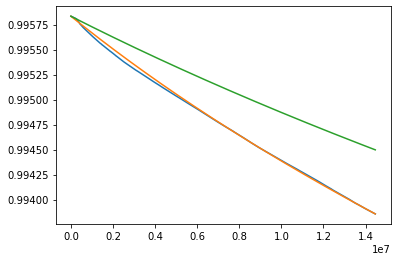

In [44]:
plt.plot(t_150, norm_loss_150)
plt.plot(t_150, norm_loss_150 - result_150.residual)
plt.plot(t_150, v_f(t_150))


In [45]:
_, data0, data1, _ = full_iteration(
    result_150.params['I_star'].value,
    result_150.params['k'].value,
    result_150.params['I_max'].value,
    I_150,
    result_150.params['dt'].value,
    n_steps=10000)
I_140 = data1[1]


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


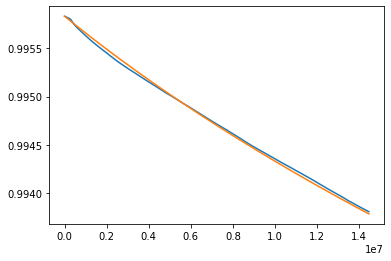

In [135]:
v_f = scipy.interpolate.interp1d(np.arange(len(vals))*result_150.params['dt']*result_150.params['scale_factor'], vals / val0, kind='cubic')
plt.plot(t_150, norm_loss_150)
plt.plot(t_150, v_f(t_150))

In [46]:
print("ANGLE: 140")
params = lmfit.Parameters()
params.add('I_star', value=result_150.params['I_star'].value, min=0.0, max=1000.0)
params.add('k', value=result_150.params['k'].value, min=0.0, max=2.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_140[0], vary=False)
params.add('ending_point', value=norm_loss_140[-1], vary=False)
params.add('dt', value=result_150.params['dt'].value, vary=False)
params.add('n_iterations', value=int(10000*t_ratio_140)+1, vary=False)
params.add('scale_factor', value=result_150.params["scale_factor"].value, vary=False)

result_140 = lmfit.minimize(resid_lmfit, params, args=(t_140, norm_loss_140, I_140))


ANGLE: 140
I_star: 77.9371141433321
k: 0.7715590263782359
dt: 1.0
Reached after 876 iterations
I_star: 77.9371141433321
k: 0.7715590263782359
dt: 1.0
Reached after 876 iterations
I_star: 77.9371141433321
k: 0.7715590263782359
dt: 1.0
Reached after 876 iterations
I_star: 77.93711815762855
k: 0.7715590263782359
dt: 1.0
Reached after 876 iterations
I_star: 77.9371141433321
k: 0.7715590297217839
dt: 1.0
Reached after 876 iterations
I_star: 157.10924272331738
k: 0.5970741022871355
dt: 1.0
Reached after 362 iterations
I_star: 84.99987389337655
k: 0.7543120691848312
dt: 1.0
Reached after 883 iterations
I_star: 84.99987796221548
k: 0.7543120691848312
dt: 1.0
Reached after 883 iterations
I_star: 84.99987389337655
k: 0.7543120727703609
dt: 1.0
Reached after 883 iterations
I_star: 88.78971754221283
k: 0.7468925971229216
dt: 1.0
Reached after 900 iterations
I_star: 86.8876406609534
k: 0.7512911196151446
dt: 1.0
Reached after 902 iterations
I_star: 85.9886387817292
k: 0.7533866931940869
dt: 1.0
Rea

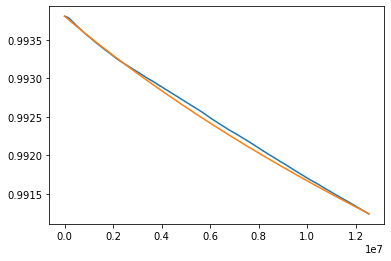

In [ ]:
plt.plot(t_140, norm_loss_140)
plt.plot(t_140, norm_loss_140 - result_140.residual)

In [47]:
_, data0, data1, _ = full_iteration(
    result_140.params['I_star'].value,
    result_140.params['k'].value,
    result_140.params['I_max'].value,
    I_140,
    result_140.params['dt'].value,
    n_steps=10000)
I_130 = data1[1]


In [48]:
print("ANGLE: 130")
params = lmfit.Parameters()
params.add('I_star', value=result_140.params['I_star'].value, min=0.0, max=1000.0)
params.add('k', value=result_140.params['k'].value, min=0.0, max=2.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_130[0], vary=False)
params.add('ending_point', value=norm_loss_130[-1], vary=False)
params.add('dt', value=result_140.params['dt'].value, vary=False)
params.add('n_iterations', value=int(10000*t_ratio_130)+1, vary=False)
params.add('scale_factor', value=result_140.params["scale_factor"].value, vary=False)

result_130 = lmfit.minimize(resid_lmfit, params, args=(t_130, norm_loss_130, I_130))


ANGLE: 130
I_star: 85.05096804662449
k: 0.7544484261580416
dt: 1.0
Reached after 14119 iterations
I_star: 85.05096804662449
k: 0.7544484261580416
dt: 1.0
Reached after 14119 iterations
I_star: 85.05096804662449
k: 0.7544484261580416
dt: 1.0
Reached after 14119 iterations
I_star: 85.05097211581104
k: 0.7544484261580416
dt: 1.0
Reached after 14119 iterations
I_star: 85.05096804662449
k: 0.7544484297416674
dt: 1.0
Reached after 14119 iterations
I_star: 145.27620419766822
k: 0.637255811270226
dt: 1.0
Reached after 5610 iterations
I_star: 90.60550246506138
k: 0.742913742414101
dt: 1.0
Reached after 14284 iterations
I_star: 90.6055065683049
k: 0.742913742414101
dt: 1.0
Reached after 14284 iterations
I_star: 90.60550246506138
k: 0.7429137461582667
dt: 1.0
Reached after 14284 iterations
I_star: 93.50737048105067
k: 0.7378128339608544
dt: 1.0
Reached after 14589 iterations
I_star: 92.11207994148451
k: 0.7406402583192063
dt: 1.0
Reached after 14626 iterations
I_star: 91.39844929528812
k: 0.74209

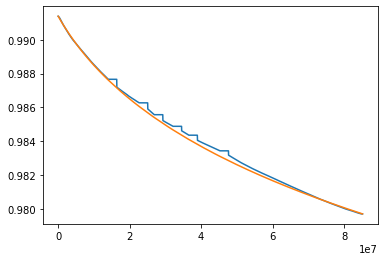

In [49]:
plt.plot(t_130, norm_loss_130)
plt.plot(t_130, norm_loss_130 - result_130.residual)

In [50]:
print("ANGLE: 160")
print("I_star:", result_160.params['I_star'].value)
print("k:", result_160.params['k'].value)
print("scale_factor:", result_160.params['scale_factor'].value)

print("ANGLE: 150")
print("I_star:", result_150.params['I_star'].value)
print("k:", result_150.params['k'].value)
print("scale_factor:", result_150.params['scale_factor'].value)

print("ANGLE: 140")
print("I_star:", result_140.params['I_star'].value)
print("k:", result_140.params['k'].value)
print("scale_factor:", result_140.params['scale_factor'].value)

print("ANGLE: 130")
print("I_star:", result_130.params['I_star'].value)
print("k:", result_130.params['k'].value)
print("scale_factor:", result_130.params['scale_factor'].value)

ANGLE: 160
I_star: 77.9389129675141
k: 0.7715633894822329
scale_factor: 50294.65633664916
ANGLE: 150
I_star: 77.93711414333211
k: 0.7715590263782359
scale_factor: 31713.390644199557
ANGLE: 140
I_star: 85.05096804662449
k: 0.7544484261580416
scale_factor: 14151.235981941307
ANGLE: 130
I_star: 90.60596351466249
k: 0.7429147760786392
scale_factor: 5961.948794542496


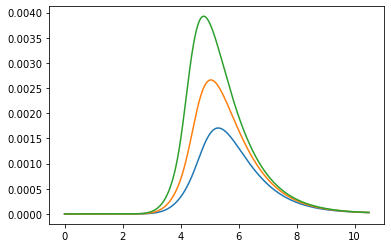

In [51]:
plt.plot(data0[0], I_160 - I_150)
plt.plot(data0[0], I_160 - I_140)
plt.plot(data0[0], I_160 - I_130)

In [150]:
%matplotlib widget

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


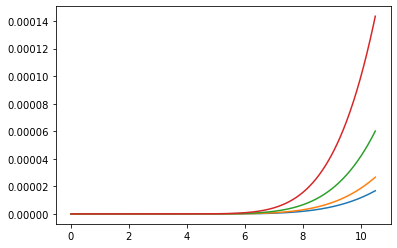

In [52]:
I_plot = np.linspace(0, 10.5, 1000)
plt.figure()

plt.plot(
    I_plot, 
    nt.D(
        I_plot, 
        result_160.params['I_star'].value,
        result_160.params['k'].value, 
        nt.standard_c(
            0.0, 10.5, 
            result_160.params['I_star'].value, 
            result_160.params['k'].value
        )
    ) / result_160.params['scale_factor'].value
)

plt.plot(
    I_plot, 
    nt.D(
        I_plot, 
        result_150.params['I_star'].value,
        result_150.params['k'].value, 
        nt.standard_c(
            0.0, 10.5, 
            result_150.params['I_star'].value, 
            result_150.params['k'].value
        )
    ) / result_150.params['scale_factor'].value
)

plt.plot(
    I_plot, 
    nt.D(
        I_plot, 
        result_140.params['I_star'].value,
        result_140.params['k'].value, 
        nt.standard_c(
            0.0, 10.5, 
            result_140.params['I_star'].value, 
            result_140.params['k'].value
        )
    ) / result_140.params['scale_factor'].value
)

plt.plot(
    I_plot, 
    nt.D(
        I_plot, 
        result_130.params['I_star'].value,
        result_130.params['k'].value, 
        nt.standard_c(
            0.0, 10.5, 
            result_130.params['I_star'].value, 
            result_130.params['k'].value
        )
    ) / result_130.params['scale_factor'].value
)

# plt.yscale("log")


In [106]:
print("ANGLE: 160")
params = lmfit.Parameters()

params.add('I_star', value=70.0, min=0.0, max=200.0)
params.add('k', value=0.9, min=0.0, max=2.0)
params.add('I_max', value=10.5, vary=False)

params.add('starting_point', value=norm_loss_160[0], vary=False)
params.add('ending_point', value=norm_loss_160[-1], vary=False)

params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

I_160 = np.exp(-np.linspace(I_min, I_max, samples))
result_160 = lmfit.minimize(resid_lmfit, params, args=(t_160, norm_loss_160, I_160))

ANGLE: 160
I_star: 70.0
k: 0.9
dt: 1.0
Reached after 2303 iterations
I_star: 70.0
k: 0.9
dt: 1.0
Reached after 2303 iterations
I_star: 70.0
k: 0.9
dt: 1.0
Reached after 2303 iterations
I_star: 70.00000043311456
k: 0.9
dt: 1.0
Reached after 2303 iterations
I_star: 70.0
k: 0.9000000014851292
dt: 1.0
Reached after 2303 iterations
I_star: 165.29566821975848
k: 0.6607489793143759
dt: 1.0
Reached after 639 iterations
I_star: 165.29567611398735
k: 0.6607489793143759
dt: 1.0
Reached after 639 iterations
I_star: 165.29566821975848
k: 0.6607489401289558
dt: 1.0
Reached after 639 iterations
I_star: 184.23491793054737
k: 0.22446733049244827
dt: 1.0
Reached after 77 iterations
I_star: 140.11683485076418
k: 0.5321525643121052
dt: 1.0
Reached after 137 iterations
I_star: 179.18635052068558
k: 0.6485326207038378
dt: 1.0
Reached after 630 iterations
I_star: 179.1863570700712
k: 0.6485326207038378
dt: 1.0
Reached after 630 iterations
I_star: 179.18635052068558
k: 0.6485325818872907
dt: 1.0
Reached after

KeyboardInterrupt: 

In [98]:
_, data0, data1, _ = full_iteration(
    result_160.params['I_star'].value,
    result_160.params['k'].value,
    result_160.params['I_max'].value,
    I_160,
    result_160.params['dt'].value,
    n_steps=10000)

I_150 = data1[1]

In [91]:
print("ANGLE: 150")
params = lmfit.Parameters()
params.add('I_star', value=result_160.params['I_star'].value, min=0.0, max=200.0)
params.add('k', value=result_160.params['k'].value, min=0.0, max=1.5)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_150[0], vary=False)
params.add('ending_point', value=norm_loss_150[-1], vary=False)
params.add('dt', value=result_160.params['dt'].value, vary=False)
params.add('n_iterations', value=int(10000*t_ratio_150)+1, vary=False)
params.add('scale_factor', value=result_160.params["scale_factor"].value, vary=False)

result_150 = lmfit.minimize(resid_fixed_dt, params, args=(t_150, norm_loss_150, I_150))


ANGLE: 150
I_star: 78.32031988198912
k: 0.7701519976595761
I_star: 78.32031988198912
k: 0.7701519976595761
I_star: 78.32031988198912
k: 0.7701519976595761
I_star: 78.32032019988249
k: 0.7701519976595761
I_star: 78.32031988198912
k: 0.770151997959792
I_star: 162.6763785356641
k: 0.5121337560805828
I_star: 3.2393910543058846
k: 0.9942931503134775
I_star: 68.88672033770966
k: 0.7441062951942081
I_star: 68.88672078575995
k: 0.7441062951942081
I_star: 68.88672033770966
k: 0.7441062952820293
I_star: 58.74573222618387
k: 0.7774814463801861
I_star: 66.10809860575
k: 0.7548803781432112
I_star: 66.10809909049013
k: 0.7548803781432112
I_star: 66.10809860575
k: 0.7548803782159336
I_star: 60.23928829116782
k: 0.7749800902315823
I_star: 60.23928885025256
k: 0.7749800902315823
I_star: 60.23928829116782
k: 0.774980090603677
I_star: 57.77464908611745
k: 0.7855180470337186
I_star: 57.77464967495287
k: 0.7855180470337186
I_star: 57.77464908611745
k: 0.7855180475625828
I_star: 52.9328835502927
k: 0.806036

KeyboardInterrupt: 

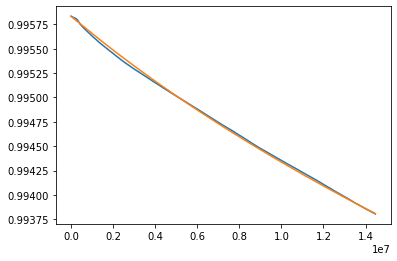

In [ ]:
plt.plot(t_150, norm_loss_150)
plt.plot(t_150, norm_loss_150 - result_150.residual)

In [ ]:
_, data0, data1, _ = full_iteration(
    result_150.params['I_star'].value,
    result_150.params['k'].value,
    result_150.params['I_max'].value,
    I_150,
    result_150.params['dt'].value,
    n_steps=10000)
I_140 = data1[1]


In [ ]:
print("ANGLE: 140")
params = lmfit.Parameters()
params.add('I_star', value=result_150.params['I_star'].value, min=0.0, max=1000.0)
params.add('k', value=result_150.params['k'].value, min=0.0, max=2.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_140[0], vary=False)
params.add('ending_point', value=norm_loss_140[-1], vary=False)
params.add('dt', value=result_150.params['dt'].value, vary=False)
params.add('n_iterations', value=int(10000*t_ratio_140)+1, vary=False)
params.add('scale_factor', value=result_150.params["scale_factor"].value, vary=False)

result_140 = lmfit.minimize(resid_lmfit, params, args=(t_140, norm_loss_140, I_140))


ANGLE: 140
I_star: 48.86508577409937
k: 0.8897985445985501
dt: 1.0
Reached after 998 iterations
I_star: 48.86508577409937
k: 0.8897985445985501
dt: 1.0
Reached after 998 iterations
I_star: 48.86508577409937
k: 0.8897985445985501
dt: 1.0
Reached after 998 iterations
I_star: 48.865089388156754
k: 0.8897985445985501
dt: 1.0
Reached after 998 iterations
I_star: 48.86508577409937
k: 0.8897985462339997
dt: 1.0
Reached after 998 iterations
I_star: 117.12574158616911
k: 0.576626266798177
dt: 1.0
Reached after 205 iterations
I_star: 54.66634719928132
k: 0.8585683160152877
dt: 1.0
Reached after 1000 iterations
I_star: 54.66635092144628
k: 0.8585683160152877
dt: 1.0
Reached after 1000 iterations
I_star: 54.66634719928132
k: 0.8585683181086183
dt: 1.0
Reached after 1000 iterations
I_star: 57.59673390512787
k: 0.8465978083953313
dt: 1.0
Reached after 1026 iterations
I_star: 56.15315600005072
k: 0.8535825798746488
dt: 1.0
Reached after 1032 iterations
I_star: 55.424486655783866
k: 0.8571423499570215

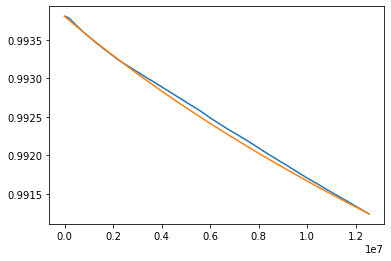

In [ ]:
plt.plot(t_140, norm_loss_140)
plt.plot(t_140, norm_loss_140 - result_140.residual)

In [ ]:
_, data0, data1, _ = full_iteration(
    result_140.params['I_star'].value,
    result_140.params['k'].value,
    result_140.params['I_max'].value,
    I_140,
    result_140.params['dt'].value,
    n_steps=10000)
I_130 = data1[1]


In [ ]:
print("ANGLE: 130")
params = lmfit.Parameters()
params.add('I_star', value=result_140.params['I_star'].value, min=0.0, max=1000.0)
params.add('k', value=result_140.params['k'].value, min=0.0, max=2.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_130[0], vary=False)
params.add('ending_point', value=norm_loss_130[-1], vary=False)
params.add('dt', value=result_140.params['dt'].value, vary=False)
params.add('n_iterations', value=int(10000*t_ratio_130)+1, vary=False)
params.add('scale_factor', value=result_140.params["scale_factor"].value, vary=False)

result_130 = lmfit.minimize(resid_lmfit, params, args=(t_130, norm_loss_130, I_130))


ANGLE: 130
I_star: 54.668602956371046
k: 0.8585815810689847
dt: 1.0
Reached after 19611 iterations
I_star: 54.668602956371046
k: 0.8585815810689847
dt: 1.0
Reached after 19611 iterations
I_star: 54.668602956371046
k: 0.8585815810689847
dt: 1.0
Reached after 19611 iterations
I_star: 54.66860667857476
k: 0.8585815810689847
dt: 1.0
Reached after 19611 iterations
I_star: 54.668602956371046
k: 0.8585815831621216
dt: 1.0
Reached after 19611 iterations
I_star: 142.77740784789648
k: 0.5491108991719864
dt: 1.0
Reached after 836 iterations
I_star: 61.99503546819146
k: 0.8274474281672413
dt: 1.0
Reached after 19481 iterations
I_star: 61.995039304199864
k: 0.8274474281672413
dt: 1.0
Reached after 19481 iterations
I_star: 61.99503546819146
k: 0.8274474307126468
dt: 1.0
Reached after 19481 iterations
I_star: 70.08010413357674
k: 0.7995457317051677
dt: 1.0
Reached after 19383 iterations
I_star: 70.08010807054637
k: 0.7995457317051677
dt: 1.0
Reached after 19383 iterations
I_star: 70.08010413357674
k:

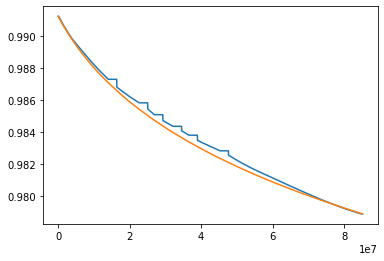

In [ ]:
plt.plot(t_130, norm_loss_130)
plt.plot(t_130, norm_loss_130 - result_130.residual)

In [ ]:
print("ANGLE: 160")
print("I_star:", result_160.params['I_star'].value)
print("k:", result_160.params['k'].value)
print("scale_factor:", result_160.params['scale_factor'].value)

print("ANGLE: 150")
print("I_star:", result_150.params['I_star'].value)
print("k:", result_150.params['k'].value)
print("scale_factor:", result_150.params['scale_factor'].value)

print("ANGLE: 140")
print("I_star:", result_140.params['I_star'].value)
print("k:", result_140.params['k'].value)
print("scale_factor:", result_140.params['scale_factor'].value)

print("ANGLE: 130")
print("I_star:", result_130.params['I_star'].value)
print("k:", result_130.params['k'].value)
print("scale_factor:", result_130.params['scale_factor'].value)

ANGLE: 160
I_star: 78.31950807846361
k: 0.7701535400737186
scale_factor: 50294.65633664916
ANGLE: 150
I_star: 48.865085774099356
k: 0.8897985445985501
scale_factor: 30253.778522499997
ANGLE: 140
I_star: 54.668602956371046
k: 0.8585815810689847
scale_factor: 12537.995079999999
ANGLE: 130
I_star: 88.58731292739652
k: 0.7519300722724276
scale_factor: 4417.037167077023


## Brute force variant

In [17]:
print("ANGLE: 160")
params = lmfit.Parameters()
params.add('I_star', value=50.0, min=20.0, max=100.0)
params.add('k', value=0.9, min=0.5, max=1.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_160[0], vary=False)
params.add('ending_point', value=norm_loss_160[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

I_160 = np.exp(-np.linspace(I_min, I_max, samples))
result_160 = lmfit.minimize(resid_lmfit, params, args=(t_160, norm_loss_160, I_160), method="brute", workers=6, Ns=20)

vals, data0, data1, _ = full_iteration(
    result_160.params['I_star'].value,
    result_160.params['k'].value,
    result_160.params['I_max'].value,
    I_160,
    result_160.params['dt'].value,
    n_steps=10000)

I_150 = data1[1]

print("ANGLE: 150")
params = lmfit.Parameters()
params.add('I_star', value=50.0, min=20.0, max=100.0)
params.add('k', value=0.9, min=0.5, max=1.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_150[0], vary=False)
params.add('ending_point', value=norm_loss_150[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_150 = lmfit.minimize(resid_lmfit, params, args=(t_150, norm_loss_150, I_150), method="brute", workers=6, Ns=20)

vals, data0, data1, _ = full_iteration(
    result_150.params['I_star'].value,
    result_150.params['k'].value,
    result_150.params['I_max'].value,
    I_150,
    result_150.params['dt'].value,
    n_steps=10000)

I_140 = data1[1]

print("ANGLE: 140")
params = lmfit.Parameters()
params.add('I_star', value=50.0, min=20.0, max=100.0)
params.add('k', value=0.9, min=0.5, max=1.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_140[0], vary=False)
params.add('ending_point', value=norm_loss_140[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_140 = lmfit.minimize(resid_lmfit, params, args=(t_140, norm_loss_140, I_140), method="brute", workers=6, Ns=20)

vals, data0, data1, _ = full_iteration(
    result_140.params['I_star'].value,
    result_140.params['k'].value,
    result_140.params['I_max'].value,
    I_140,
    result_140.params['dt'].value,
    n_steps=10000)

I_130 = data1[1]

print("ANGLE: 130")
params = lmfit.Parameters()
params.add('I_star', value=50.0, min=20.0, max=100.0)
params.add('k', value=0.9, min=0.5, max=1.0)
params.add('I_max', value=10.5, vary=False)
params.add('starting_point', value=norm_loss_130[0], vary=False)
params.add('ending_point', value=norm_loss_130[-1], vary=False)
params.add('dt', value=-1, vary=False)
params.add('scale_factor', value=-1, vary=False)
params.add('n_iterations', value=-1, vary=False)

result_130 = lmfit.minimize(resid_lmfit, params, args=(t_130, norm_loss_130, I_130), method="brute", workers=6, Ns=20)

ANGLE: 160
I_star: 20.0
 k: 0.5I_star: 20.0 k: 0.9473684210526315
I_star: 24.210526315789473 k: 0.868421052631579I_star: 28.421052631578945
 k: 0.7894736842105263
I_star: 32.631578947368425 k: 0.7105263157894737I_star: 36.84210526315789
 k: 0.631578947368421


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halve

I_star: 36.84210526315789 k: 0.6578947368421053
I_star: 32.631578947368425 k: 0.7368421052631579
I_star: 28.421052631578945 k: 0.8157894736842105
I_star: 20.0 k: 0.9736842105263157
I_star: 24.210526315789473 k: 0.8947368421052632
I_star: 32.631578947368425 k: 0.763157894736842
I_star: 28.421052631578945 k: 0.8421052631578947
I_star: 36.84210526315789 k: 0.6842105263157895
I_star: 24.210526315789473 k: 0.9210526315789473
I_star: 20.0 k: 1.0
I_star: 20.0 k: 0.5263157894736842
I_star: 28.421052631578945 I_star: 32.631578947368425k: 0.868421052631579 k: 0.7894736842105263

I_star: 24.210526315789473 k: 0.9473684210526315
I_star: 36.84210526315789 k: 0.7105263157894737
I_star: 24.210526315789473 k: 0.9736842105263157
I_star: 32.631578947368425 k: 0.8157894736842105
I_star: 28.421052631578945 k: 0.8947368421052632
I_star: 24.210526315789473 k: 0.5
I_star: 20.0 k: 0.5526315789473684I_star: 36.84210526315789
 k: 0.7368421052631579
I_star: 24.210526315789473 k: 1.0
I_star: 32.631578947368425 k:

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


ANGLE: 150
I_star: 20.0
 k: 0.5I_star: 20.0 k: 0.9473684210526315
I_star: 24.210526315789473 k: 0.868421052631579
k: 0.7894736842105263I_star: 28.421052631578945 
I_star: 32.631578947368425 k: 0.7105263157894737
I_star: 36.84210526315789 k: 0.631578947368421
I_star: 28.421052631578945 I_star: 24.210526315789473k: 0.8157894736842105 
k: 0.8947368421052632
I_star: 20.0 k: 0.9736842105263157
I_star: 32.631578947368425 k: 0.7368421052631579
I_star: 36.84210526315789 k: 0.6578947368421053
I_star: 28.421052631578945 k: 0.8421052631578947
I_star: 20.0 k: 1.0
I_star: 24.210526315789473 k: 0.9210526315789473
I_star: 32.631578947368425 k: 0.763157894736842
I_star: 36.84210526315789 k: 0.6842105263157895
I_star: 28.421052631578945 k: 0.868421052631579
I_star: 24.210526315789473 k: 0.9473684210526315
I_star: 20.0 k: 0.5263157894736842
I_star: 32.631578947368425 k: 0.7894736842105263
I_star: 36.84210526315789 k: 0.7105263157894737
I_star: 24.210526315789473 k: 0.9736842105263157
I_star: 28.42105263

In [15]:
print("ANGLE: 160")
print("I_star:", result_160.params['I_star'].value)
print("k:", result_160.params['k'].value)
print("scale_factor:", result_160.params['scale_factor'].value)

print("ANGLE: 150")
print("I_star:", result_150.params['I_star'].value)
print("k:", result_150.params['k'].value)
print("scale_factor:", result_150.params['scale_factor'].value)

print("ANGLE: 140")
print("I_star:", result_140.params['I_star'].value)
print("k:", result_140.params['k'].value)
print("scale_factor:", result_140.params['scale_factor'].value)

print("ANGLE: 130")
print("I_star:", result_130.params['I_star'].value)
print("k:", result_130.params['k'].value)
print("scale_factor:", result_130.params['scale_factor'].value)

ANGLE: 160
I_star: 41.05263157894737
k: 0.9473684210526315
scale_factor: 49057.90249230533
ANGLE: 150
I_star: 100.0
k: 1.0
scale_factor: 0.16028758419608516
ANGLE: 140
I_star: 100.0
k: 1.0
scale_factor: 0.002512523562181876
ANGLE: 130
I_star: 100.0
k: 1.0
scale_factor: 0.0008509240265911771


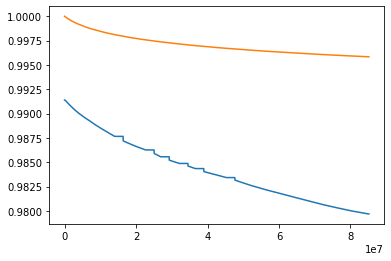

In [16]:
plt.plot(t_130, norm_loss_130)
plt.plot(t_130, norm_loss_130 - result_130.residual)


In [14]:
result_160

In [178]:
result_150

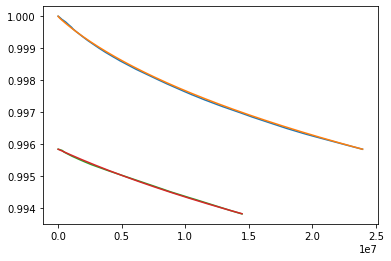

In [180]:
plt.plot(t_160, norm_loss_160, label='160')
plt.plot(t_160, norm_loss_160 - result_160.residual, label='160 - residual')
plt.plot(t_150, norm_loss_150, label='150')
plt.plot(t_150, norm_loss_150 - result_150.residual, label='150 - residual')

In [139]:
I_star = 50.0
k = 0.9
exponent = 1/(k*2)

I_min = 0.0
I_max = 10.5
samples = 3000

dt = 1.0

In [140]:
data = test_parameters(I_star, k, I_max, 1.0, normalized_loss[-1])

dt: 1.0


/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


  0%|          | 0/100000 [00:00<?, ?it/s]

Reached after 571 iterations


  0%|          | 0/10000 [00:00<?, ?it/s]

In [145]:
data[2]

0.0571

In [146]:
np.arange(len(data[1]))*data[2]

array([0.000000e+00, 5.710000e-02, 1.142000e-01, ..., 5.708858e+02,
       5.709429e+02, 5.710000e+02])

In [141]:
m_data = align_time(t_160, normalized_loss, np.arange(len(data[1]))*data[2], data[1])

41926.8938988529


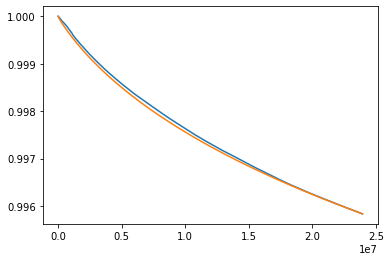

In [143]:
plt.plot(m_data[0], m_data[1])
plt.plot(m_data[0], m_data[2])
print(m_data[3])

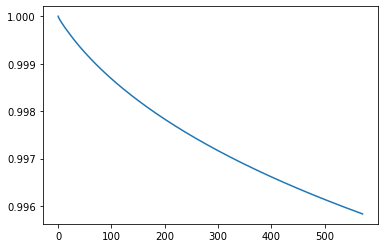

In [136]:
plt.plot(np.arange(len(data[1])) * data[2], data[1])

In [71]:
I0 = np.exp(-np.linspace(I_min, I_max, samples))

In [72]:
engine1 = cn.cn_generic(I_min, I_max, I0, dt, lambda x : nt.D(x, I_star, exponent, nt.standard_c(0.0, I_max, I_star, exponent), True), False)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/axel_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


In [73]:
data = iterate_to_loss(engine1, 0.9, 0.89)

  0%|          | 0/100000 [00:00<?, ?it/s]

Reached after 175 iterations


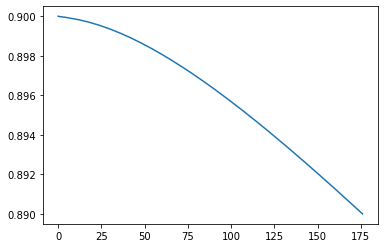

In [74]:
plt.plot(data[1])

In [56]:
data = engine1.current(1000, 1)

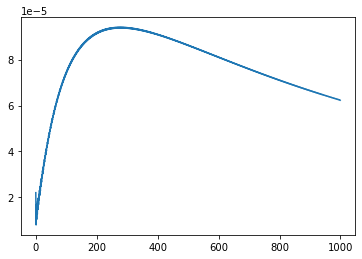

In [57]:
plt.plot(data[0], data[1])

In [ ]:
data = engine1.get_data_with_x()
val0 = scipy.integrate.trapz(data[1], data[0])

### Gathering B2 data to fit...

In [12]:
TURNS_PER_SECOND = 11245.0

In [13]:
from dataclasses import dataclass

@dataclass
class LossSample:
    loss: np.ndarray
    loss_t: np.ndarray
    loss_timestamp: np.ndarray

    intensity: np.ndarray
    intensity_t: np.ndarray
    intensity_timestamp: np.ndarray

    angle: float
    wire: bool
    octupole: bool

In [14]:
with open("loss_list_b2.pkl", "rb") as f:
    loss_list_b2 = pickle.load(f)

with open("loss_list_cont_b2.pkl", "rb") as f:
    loss_list_cont_b2 = pickle.load(f)

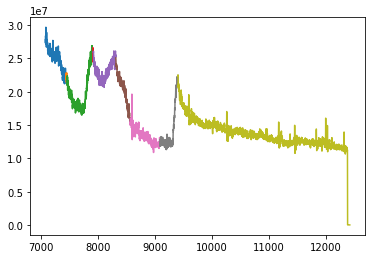

In [15]:
for b in loss_list_cont_b2[17:]:
    plt.plot(b.loss_t, b.loss, label=str(b.angle))

In [16]:
intensity_0 = loss_list_cont_b2[0].intensity[0]
data_block = []
beam_now = 1.0

for b in loss_list_cont_b2:
    turns = (b.loss_t) * TURNS_PER_SECOND
    turns_0 = (b.loss_t - b.loss_t[0]) * TURNS_PER_SECOND
    loss = b.loss / TURNS_PER_SECOND

    relative_loss = []

    for i in range(len(loss)):
        relative_loss.append(
            beam_now - scipy.integrate.trapz(loss[:i], turns[:i]) / intensity_0
        )
    
    data_block.append((turns_0, relative_loss, turns, loss))
    beam_now = relative_loss[-1]

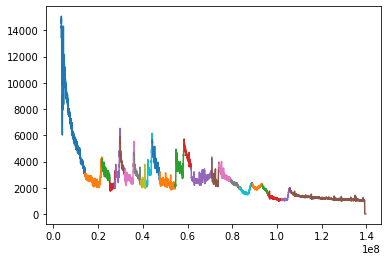

In [17]:
for d in data_block:
    plt.plot(d[2], d[3])

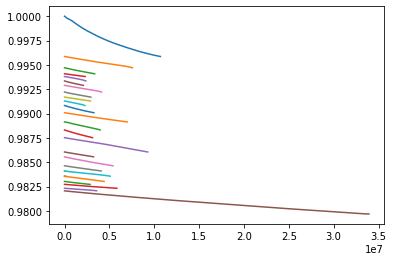

In [18]:
for d in data_block:
    plt.plot(d[0], d[1])

In [24]:
data_block[0][1]

[1.0,
 1.0,
 0.9999905513648878,
 0.9999868548997431,
 0.999980888602299,
 0.9999775147437997,
 0.9999709379606277,
 0.9999615446430843,
 0.9999521296456249,
 0.9999427635965522,
 0.9999334119816016,
 0.9999235949841101,
 0.999915808880068,
 0.9999068358914565,
 0.9998978246035987,
 0.9998887838019278,
 0.9998795219953952,
 0.9998702796806055,
 0.9998612175400569,
 0.9998534858000302,
 0.9998462447928051,
 0.99983928399028,
 0.999832655802632,
 0.9998262439072728,
 0.9998196633683328,
 0.9998129042014989,
 0.9998063979585249,
 0.9998003816086949,
 0.9997946010370765,
 0.9997927173743948,
 0.9997889428212299,
 0.9997868082317409,
 0.999782908678258,
 0.9997767982049298,
 0.9997711745689284,
 0.9997656436344551,
 0.9997603693680468,
 0.9997554181855308,
 0.9997503318707148,
 0.9997451962503272,
 0.9997403857033828,
 0.9997357939253809,
 0.9997313756884684,
 0.9997268656636283,
 0.9997223896381829,
 0.9997179431334619,
 0.9997136870479166,
 0.9997096098282912,
 0.9997054517196312,
 0.9997

In [37]:
fit_results = []

I_0 = np.exp(-np.linspace(0.0, 10.5, 3000))
I_list = [I_0]

for i, d in tqdm(enumerate(data_block), total=len(data_block)):
    print("i:", i)
    if i == 18:
        print("skipping 18")
        fit_results.append(fit_results[-1])
        I_list.append(I_list[-1])
        continue
    params = lmfit.Parameters()
    params.add('I_max', value=10.5, vary=False)
    
    params.add('starting_point', value=d[1][0], vary=False)
    params.add('ending_point', value=d[1][-1], vary=False)

    params.add('dt', value=-1, vary=False)
    params.add('scale_factor', value=-1, vary=False)
    params.add('n_iterations', value=-1, vary=False)
    print(d[1][0], d[1][-1])
    if i==0:
        params.add('I_star', value=40.0, min=20.0, max=100.0)
        params.add('k', value=0.75, min=0.5, max=1.0)
    else:
        params.add('I_star', value=fit_results[i-1].params['I_star'].value, min=20.0, max=100.0)
        params.add('k', value=fit_results[i-1].params['k'].value, min=0.5, max=1.0)

    result = lmfit.minimize(resid_lmfit, params, args=(d[0], d[1], I_0), method="brute", workers=20, Ns=20)
    fit_results.append(result)
    
    print("I_star:", result.params['I_star'].value)
    print("k:", result.params['k'].value)
    print("scale_factor:", result.params['scale_factor'].value)

    vals, data0, data1, _ = full_iteration(
        result.params['I_star'].value,
        result.params['k'].value,
        result.params['I_max'].value,
        I_0,
        result.params['dt'].value,
        n_steps=10000)

    I_0 = data1[1]
    I_list.append(I_0)

  0%|          | 0/26 [00:00<?, ?it/s]

i: 0
1.0 0.9958632309293568


/gpfs/gpfs/gpfs_maestro_home_new/hpc/camontan/wire_compensator_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/gpfs/gpfs/gpfs_maestro_home_new/hpc/camontan/wire_compensator_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/gpfs/gpfs/gpfs_maestro_home_new/hpc/camontan/wire_compensator_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/gpfs/gpfs/gpfs_maestro_home_new/hpc/camontan/wire_compensator_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
/gpfs/gpfs/gpfs_maestro_home_new/hpc/camontan/wire_compensator_d

Reached maximum iterations
I_star: 83.15789473684211, k: 1.0
Reached maximum iterations
I_star: 91.57894736842105, k: 0.9736842105263157
Reached maximum iterations
I_star: 100.0, k: 0.9473684210526315
Reached maximum iterations
I_star: 87.36842105263158, k: 1.0
Reached maximum iterations
I_star: 95.78947368421052, k: 0.9736842105263157
Reached maximum iterations
I_star: 91.57894736842105, k: 1.0
Reached maximum iterations
I_star: 100.0, k: 0.9736842105263157
Reached maximum iterations
I_star: 95.78947368421052, k: 1.0
Reached maximum iterations
I_star: 100.0, k: 1.0
Reached maximum iterations
I_star: 100.0, k: 1.0


/gpfs/gpfs/gpfs_maestro_home_new/hpc/camontan/wire_compensator_data/nekhoroshev_tools.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


I_star: 41.05263157894737
k: 0.9473684210526315
scale_factor: 22162.705199678425
i: 1
0.9958632309293568 0.9947049611967
Reached maximum iterations
I_star: 91.57894736842105, k: 1.0
Reached maximum iterations
I_star: 95.78947368421052, k: 1.0
Reached maximum iterations
I_star: 100.0, k: 1.0
I_star: 87.36842105263158
k: 0.7368421052631579
scale_factor: 32770.02327378789
i: 2
0.9947049611967 0.9940873332146517
I_star: 49.473684210526315
k: 0.8947368421052632
scale_factor: 21679.852161290328
i: 3
0.9940873332146517 0.9938035152577743
I_star: 45.26315789473684
k: 0.8947368421052632
scale_factor: 30996.842500000035
i: 4
0.9938035152577743 0.9933495871730573
I_star: 78.94736842105263
k: 0.6842105263157895
scale_factor: 30421.04083333332
i: 5
0.9933495871730573 0.9928957701129626
I_star: 36.84210526315789
k: 0.9736842105263157
scale_factor: 27161.494431753203
i: 6
0.9928957701129626 0.9922118086934698
I_star: 91.57894736842105
k: 0.6842105263157895
scale_factor: 35575.78701512933
i: 7
0.99221

In [39]:
with open("fit_results_b2.pkl", "wb") as f:
    pickle.dump((fit_results, I_list), f)

In [ ]:
with open("fit_results_b2.pkl", "rb") as f:
    fit_results, I_list = pickle.load(f)

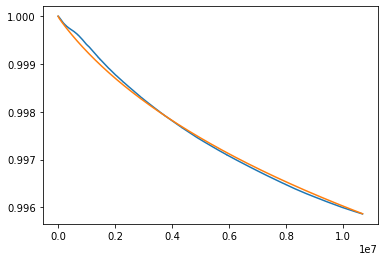

In [40]:
idx = 0
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

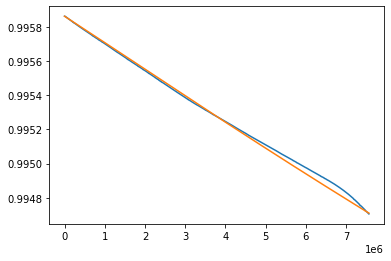

In [41]:
idx = 1
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

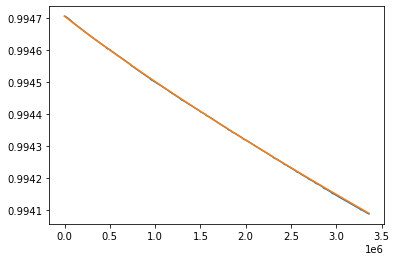

In [42]:
idx = 2
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

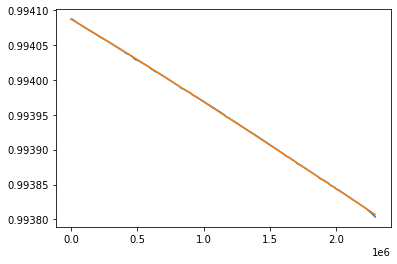

In [43]:
idx = 3
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

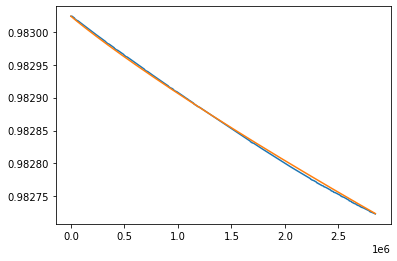

In [44]:
idx = -4
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

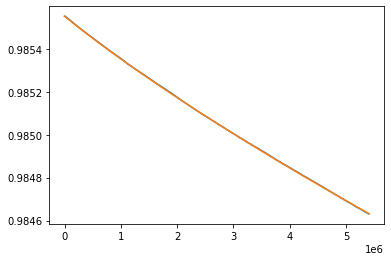

In [45]:
idx = -10
plt.plot(data_block[idx][0], data_block[idx][1])
plt.plot(data_block[idx][0], data_block[idx][1] - fit_results[idx].residual)

In [46]:
for f in fit_results:
    print("{:.2f}, {:.2f}, {:.2}, {:.2f}".format(f.params['I_star'].value, f.params['k'].value, f.params["dt"].value, f.params["scale_factor"].value))

41.05, 0.95, 0.048, 22162.71
87.37, 0.74, 0.023, 32770.02
49.47, 0.89, 0.015, 21679.85
45.26, 0.89, 0.0074, 30996.84
78.95, 0.68, 0.0078, 30421.04
36.84, 0.97, 0.0077, 27161.49
91.58, 0.68, 0.012, 35575.79
100.00, 0.71, 0.011, 27952.71
36.84, 0.95, 0.009, 32112.85
66.32, 0.71, 0.008, 28250.11
36.84, 0.95, 0.014, 23208.72
45.26, 0.87, 0.023, 29838.08
45.26, 0.84, 0.02, 19846.41
70.53, 0.76, 0.024, 13032.06
91.58, 0.68, 0.04, 23173.67
70.53, 0.74, 0.013, 24075.63
41.05, 0.89, 0.032, 17111.15
70.53, 0.76, 0.024, 16798.13
70.53, 0.76, 0.024, 16798.13
95.79, 0.68, 0.022, 22945.88
28.42, 0.87, 0.0007, 19243.41
87.37, 0.68, 0.017, 25480.13
70.53, 0.76, 0.012, 24521.66
36.84, 0.95, 0.02, 29328.66
95.79, 0.66, 0.011, 33107.78
28.42, 1.00, 0.11, 31977.67


In [ ]:
for f in fit_results:
    print("{:.2f}, {:.2f}, {:.2}, {:.2f}".format(f.params['I_star'].value, f.params['k'].value, f.params["dt"].value, f.params["scale_factor"].value))